<img align='left' src = https://linea.org.br/wp-content/themes/LIneA/imagens/logo-header.jpg width=150 style='padding: 20px'> 

# Tutorial: particionamento de dados com Hipscat  

Passo-a-passo para conversão de catálogos astronômicos para o formato Hipscat. 

Contato 1: Julia Gschwend ([julia@linea.org.br](mailto:julia@linea.org.br))

Contato 2: Luigi Silva ([luigi.silva@linea.org.br](mailto:luigi.silva@linea.org.br))
<br>
Última verificação: 09/05/2024
<br>



#### Acknowledgements

<font color='red'> texto pedindo citação - ver modelo no jupyterhub do dirac/lincc </font>

'_Esta pesquisa utilizou recursos computacionais da Associação Laboratório Interinstitucional de e-Astronomia (LIneA) com o apoio financeiro do INCT do e-Universo (Processo n.º 465376/2014-2)._' 

LIneA

LINCC Frameworks 


# Introdução

<font color='red'> conceito healpix </font>

<font color='red'> conceito hipscat </font>

<font color='red'> conceito x-match espacial </font>

<font color='red'> desafios técnicos, escalabilidade, objetos nas bordas, etc </font>



# Importação das bibliotecas e configurações

Requisitos para este notebook:

* **Bibliotecas essenciais**: hipscat, hipscat_import, lsdb.
* **Bibliotecas gerais**: numpy, tables_io, astropy. 
* **Bibliotecas de visualização**: bokeh, holoviews, geoviews, datashader, matplotlib.
* **Bibliotecas de manipulação de dados**: pandas, geopandas.
* **Bibliotecas para a obtenção de dados**: pzserver, dblinea.
* **Arquivo auxiliar**: [des-round19-poly.txt](https://github.com/kadrlica/skymap/blob/master/skymap/data/des-round19-poly.txt) (contorno da área coberta pelo levantamento do DES DR2, i.e., DES _footprint_, 2019 version).

Faça o download do arquivo `des-round19-poly.txt` do repositório [kadrlica/skymap](https://github.com/kadrlica/skymap) no GitHub:

In [1]:
#! wget https://raw.githubusercontent.com/kadrlica/skymap/master/skymap/data/des-round19-poly.txt -O des-round19-poly.txt 

## Importações

In [61]:
### GERAL
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import time

import matplotlib.pyplot as plt
import tables_io
import psutil
import sys
import math

from shapely.geometry import Polygon

### ASTROPY
from astropy.coordinates import SkyCoord
from astropy import units as u

# BOKEH
import bokeh
from bokeh.io import output_notebook, show, output_file, reset_output
from bokeh.models import ColumnDataSource, Range1d, HoverTool, CustomJSHover
from bokeh.models import CDSView, GroupFilter
from bokeh.plotting import figure, gridplot
from bokeh.transform import factor_cmap

# HOLOVIEWS
import holoviews as hv
from holoviews import streams, opts
from holoviews.operation import histogram
from holoviews.operation.datashader import datashade, rasterize, shade, dynspread, spread
from holoviews.plotting.util import process_cmap

# GEOVIEWS
import geoviews as gv
import geoviews.feature as gf
from cartopy import crs

### HIPSCAT
import hipscat_import.pipeline as runner
from hipscat_import.catalog.arguments import ImportArguments
from hipscat_import.catalog.file_readers import CsvReader
# For files and directories manipulation
from pathlib import Path
# Explore the HiPSCat catalogs and plot sky maps
from hipscat.catalog import Catalog
from hipscat.inspection import plot_pixels

### LDSB
import lsdb

### PZ SERVER
from pzserver import PzServer 

# DATASHADER
import datashader as dsh

# DB LIneA
from dblinea import DBBase

Imprimindo as versões do Python, Numpy, Bokeh e Holoviews:

In [3]:
print('Python version: ' + sys.version)
print('Bokeh version: ' + bokeh.__version__)
print('HoloViews version: ' + hv.__version__)
print("Datashader version: " + dsh.__version__)

Python version: 3.10.14 | packaged by conda-forge | (main, Mar 20 2024, 12:45:18) [GCC 12.3.0]
Bokeh version: 3.4.1
HoloViews version: 1.18.3
Datashader version: 0.16.1


## Configurações

### Configurações das bibliotecas

Definindo o número de linhas que o pandas irá exibir.

In [4]:
pd.set_option('display.max_rows', 10)

Configurando o holoviews e o geoviews para trabalhar com o bokeh:

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
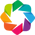

In [5]:
hv.extension('bokeh')

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
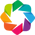

In [6]:
gv.extension('bokeh')

Configurando os plots do bokeh para serem em linha:

In [7]:
output_notebook()

Loading BokehJS ...

Configurando os plots do matplotlib para serem em linha:

In [8]:
%matplotlib inline

Lendo o token e definindo a classe PzServer.

In [9]:
with open('/home/luigi.silva/token.txt', 'r') as file:
    token = file.read().rstrip()
pz_server = PzServer(token=token, host="pz-dev") 

### Configurações dos plots de distribuição de objetos

Definindo os parâmetros gerais para os plots de distribuição de objetos utilizando geoviews e datashader.

In [10]:
height = 500    ### Altura do plot.
width = 1000    ### Largura do plot.
padding = 0.05  ### Padding do plot.
xlabel = 'R.A.' ### Label para o eixo x.
ylabel = 'Dec.' ### Label para o eixo y.

Definindo os labels de R.A. e DEC. a serem exibidos nos plots de distribuição de objetos utilizando geoviews e datashader.

In [11]:
longitudes = np.arange(30, 360, 30)
latitudes = np.arange(-75, 76, 15)

lon_labels = [f"{lon}°" for lon in longitudes]
lat_labels = [f"{lat}°" for lat in latitudes]

labels_data = {
    "lon": list(np.flip(longitudes)) + [-180] * len(latitudes),
    "lat": [0] * len(longitudes) + list(latitudes),
    "label": lon_labels + lat_labels,
}

df_labels = pd.DataFrame(labels_data)

labels_plot = gv.Labels(df_labels, kdims=["lon", "lat"], vdims=["label"]).opts(
    text_font_size="12pt",
    text_color="black",
    text_align='right',
    text_baseline='bottom',
    projection=crs.Mollweide()
)

Definindo o grid dos gráficos.

In [12]:
grid = gf.grid()

# Caracterização da amostra de exemplo

## Lendo o footprint do DES

A seguir, vamos ler o footprint do DES DR2 e já aplicar uma conversão de coordenadas em R.A. e DEC.

In [13]:
foot_ra, foot_dec = np.loadtxt('des-round19-poly.txt', unpack=True)
foot_coords = SkyCoord(ra=-foot_ra*u.degree, dec=foot_dec*u.degree, frame='icrs')
foot_df = pd.DataFrame({'foot_ra': np.array(foot_coords.ra.wrap_at(180*u.degree)), 
                        'foot_dec': np.array(foot_coords.dec)})

Já vamos definir também a curva do footprint do DES, para os plots de distribuição de objetos.

In [14]:
ra_dec_foot = gv.Path((-foot_ra, foot_dec)).opts(line_width=3, color='orange')

## Dados espectroscópicos

### Amostra pública de *redshifts* espectroscópicos - Completa

O produto [Public spec-z compilation](https://pz-server-dev.linea.org.br/product/26_public_specz_compilation) é um compilado de catálogos de diferentes levantamentos os quais foram coletados ao longo dos anos de operação do Dark Energy Survey (DES) e agrupados sistematicamente pela ferramenta DES Science Portal (pipeline Spectroscopic Sample) para formar a base de um conjunto de treinamento para algoritmos de cálculo de *redshifts* fotométricos baseados em machine learning. 

In [15]:
#specz = pz_server.get_product('26_public_specz_compilation')

In [16]:
#specz.display_metadata()

In [17]:
#specz.data.describe()

In [18]:
#specz.plot()

### Amostra utilizada nos testes - Seleção do 2dflens

Como dito anteriormente, o produto [Public spec-z compilation](https://pz-server-dev.linea.org.br/product/26_public_specz_compilation) é um compilado de *redshifts* espectroscópicos de vários levantamentos astronômicos. Muitos desses levantamentos observaram regiões comuns do céu. Ao agrupar todas as medidas em um catálogo único, geralmente há medidas múltiplas de *redshift* espectroscópico para um mesmo objeto. Para identificar esses casos, o *pipeline* Spectroscopic Sample faz uma combinação espacial entre as coordenadas equatoriais de "todos contra todos" com um raio de busca de 1.0 *arcsec* de cada objeto. Então, ele aplica uma seleção para manter apenas uma medida para cada objeto extragaláctico presente na amostra, seguindo o critério abaixo para escolha e desempate:

1. medida com a maior _flag_ de qualidade (`flag_des`)
2. medida com o menor erro no *redshift* (`err_z`)
3. medida obtida pelo levantamento mais recente

Portanto, os objetos do levantamento 2dflens apresentados aqui são aqueles que permaneceram após a seleção considerando todos os catálogos presentes no produto [Public spec-z compilation](https://pz-server-dev.linea.org.br/product/26_public_specz_compilation). Um corte de qualidade também foi aplicado onde apenas objetos com flag_des ⩾ 3 foram incluídos na amostra.

#### Todos os objetos do 2dflens, contidos no produto Public spec-z compilation

Pegando o produto referente ao 2dflens no pzserver:

In [19]:
specz = pz_server.get_product('52_2dflens_public_specz')

Connecting to PZ Server...
Done!


Mostrando os metadados do produto:

In [20]:
#specz.display_metadata()

Mostrando as estatísticas básicas dos dados:

In [21]:
specz.data.describe()

ra           dec             z    err_z      flag_des  \
count  63240.000000  63240.000000  63240.000000  63240.0  63240.000000   
mean     164.605564    -23.708983      0.343966     99.0      3.730487   
std      136.720066     11.630184      0.240018      0.0      0.443710   
min        0.002231    -35.747117      0.001000     99.0      3.000000   
25%       30.338937    -31.928488      0.166220     99.0      3.000000   
50%      165.625466    -29.353255      0.293250     99.0      4.000000   
75%      335.988548     -8.938086      0.515563     99.0      4.000000   
max      359.993683     -0.957408      4.688020     99.0      4.000000   

        flag_survey  id_spec  
count  63240.000000  63240.0  
mean       3.782005   9999.0  
std        0.570116      0.0  
min        3.000000   9999.0  
25%        3.000000   9999.0  
50%        4.000000   9999.0  
75%        4.000000   9999.0  
max        6.000000   9999.0

Fazendo uma cópia do dataframe para fazer os plots.

In [22]:
df_2dflens_all = specz.data.copy()

**Plot**

Definindo os pontos a serem utilizados no plot:

In [23]:
df_input = df_2dflens_all

## Usando apenas uma fração dos dados:
frac = 0.05  
input_sample_for_plots = df_input.sample(frac=frac, axis='index')
assert len(input_sample_for_plots) == round(frac * len(df_input))

## Using all data:
input_sample_for_plots = df_input  ## Comment this line to use a fraction of the data.

print("Total number of objects in the sample: "+str(len(df_input)))
print("Number of objects used in the plots: "+str(len(input_sample_for_plots)))

Total number of objects in the sample: 63240
Number of objects used in the plots: 63240


Redefinindo as coordenadas R.A. e DEC. para os plots:

In [24]:
coords = SkyCoord(ra=-np.array(input_sample_for_plots.ra)*u.degree, 
                  dec=np.array(input_sample_for_plots.dec)*u.degree, frame='icrs')
input_sample_for_plots.ra = np.array(coords.ra.wrap_at(180*u.degree))
input_sample_for_plots.dec = np.array(coords.dec)

Fazendo o plot com o geoviews e datashader:

In [25]:
%%time
title = 'Distribuição Espacial - Todos os dados do 2dflens' ### Título do plot.

### Defining the points in geoviews.
ra_dec_points = gv.Points((input_sample_for_plots['ra'],input_sample_for_plots['dec']), kdims=['ra', 'dec'])

### Defining the projected points using cartopy Mollweide().
projected = gv.operation.project(ra_dec_points, projection=crs.Mollweide())

### Using datashader.
dsh_points = dynspread(rasterize(projected).opts(cmap="Viridis", cnorm='log'))
dsh_points = dsh_points.opts(width=width, height=height, padding=padding, title=title, toolbar='above', colorbar=True, tools=['box_select'])

### Plotting.
dsh_points * ra_dec_foot * grid * labels_plot

CPU times: user 79.6 ms, sys: 11.1 ms, total: 90.7 ms
Wall time: 87.5 ms


:DynamicMap   []
   :Overlay
      .Image.I  :Image   [ra,dec]   (ra_dec Count)
      .Path.I   :Path   [Longitude,Latitude]
      .Grid.I   :Feature   [Longitude,Latitude]
      .Labels.I :Labels   [lon,lat]   (label)

#### Objetos do 2dflens filtrados para pertencerem ao footprint do DES

A seguir, faremos um filtro para pegar dados dentro do footprint do DES.

**Filtro simples utilizando o pandas**

O filtro a seguir pega objetos com $ra<90$ ou $ra>359$, e $dec < -15$.

In [26]:
df_2dflens_filt = specz.data.query("ra > 359 | ra < 90. & dec < -15.").copy()

Estatística básica desses dados filtrados:

In [27]:
df_2dflens_filt.describe()

ra           dec             z    err_z      flag_des  \
count  26652.000000  26652.000000  26652.000000  26652.0  26652.000000   
mean      33.268846    -30.771159      0.342813     99.0      3.753489   
std       53.858067      2.024508      0.248144      0.0      0.430987   
min        0.002231    -35.723279      0.001010     99.0      3.000000   
25%       11.858320    -32.484795      0.166837     99.0      4.000000   
50%       25.023028    -30.907806      0.284645     99.0      4.000000   
75%       39.911329    -29.043815      0.504690     99.0      4.000000   
max      359.993683    -26.253114      4.688020     99.0      4.000000   

        flag_survey  id_spec  
count  26652.000000  26652.0  
mean       3.754465   9999.0  
std        0.433799      0.0  
min        3.000000   9999.0  
25%        4.000000   9999.0  
50%        4.000000   9999.0  
75%        4.000000   9999.0  
max        6.000000   9999.0

**Filtro utilizando o geopandas**

Fazendo um polígono com geopandas, que conterá a geometria do footprint do DES.

In [28]:
! mkdir -p geopandas-des-footprint

In [29]:
#lat_point_list = foot_df['foot_dec']
#lon_point_list = foot_df['foot_ra']

#polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
#polygon = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon_geom])       

#polygon.to_file(filename='./geopandas-des-footprint/polygon.geojson', driver='GeoJSON')
#polygon.to_file(filename='./geopandas-des-footprint/polygon.gpkg', driver="GPKG")
#polygon.to_file(filename='./geopandas-des-footprint/polygon.shp', driver="ESRI Shapefile")

Lendo essa geometria.

In [30]:
#world = gpd.read_file('./geopandas-des-footprint/polygon.shp')

Transformando o pandas datframe em um geopandas dataframe.

In [31]:
#gdf = gpd.GeoDataFrame(df_2dflens_all,
#                       geometry=gpd.points_from_xy(df_2dflens_all.ra, 
#                                                   df_2dflens_all.dec)) 

Aplicando o filtro para guardar apenas objetos que estejam dentro do footprint do DES.

In [32]:
#pip = gdf.within(world.loc[0, 'geometry'])
#df_2dflens_filt = gdf.loc[pip].copy()

**Plot**

Definindo os pontos a serem utilizados no plot:

In [33]:
df_input = df_2dflens_filt

## Usando apenas uma fração dos dados:
frac = 0.05  
input_sample_for_plots = df_input.sample(frac=frac, axis='index')
assert len(input_sample_for_plots) == round(frac * len(df_input))

## Using all data:
input_sample_for_plots = df_input   ## Comment this line to use a fraction of the data.

print("Total number of objects in the sample: "+str(len(df_input)))
print("Number of objects used in the plots: "+str(len(input_sample_for_plots)))

Total number of objects in the sample: 26652
Number of objects used in the plots: 26652


Redefinindo as coordenadas R.A. e DEC. para os plots:

In [34]:
coords = SkyCoord(ra=-np.array(input_sample_for_plots.ra)*u.degree, 
                  dec=np.array(input_sample_for_plots.dec)*u.degree, frame='icrs')
input_sample_for_plots.ra = np.array(coords.ra.wrap_at(180*u.degree))
input_sample_for_plots.dec = np.array(coords.dec)

Fazendo o plot dos dados filtrados com o geoviews e datashader:

In [35]:
%%time
title = 'Distribuição Espacial - Dados do 2dflens filtrados' ### Título do plot.

### Defining the points in geoviews.
ra_dec_points = gv.Points((input_sample_for_plots['ra'],input_sample_for_plots['dec']), kdims=['ra', 'dec'])

### Defining the projected points using cartopy Mollweide().
projected = gv.operation.project(ra_dec_points, projection=crs.Mollweide())

### Using datashader.
dsh_points = dynspread(rasterize(projected).opts(cmap="Viridis", cnorm='log'))
dsh_points = dsh_points.opts(width=width, height=height, padding=padding, title=title, toolbar='above', colorbar=True, tools=['box_select'])

### Plotting.
dsh_points * ra_dec_foot * grid * labels_plot

CPU times: user 65.8 ms, sys: 10.1 ms, total: 75.9 ms
Wall time: 71.8 ms


:DynamicMap   []
   :Overlay
      .Image.I  :Image   [ra,dec]   (ra_dec Count)
      .Path.I   :Path   [Longitude,Latitude]
      .Grid.I   :Feature   [Longitude,Latitude]
      .Labels.I :Labels   [lon,lat]   (label)

## Dados fotométricos

### Lendo os dados do DES DR2, contidos na região do 2dflens, com a biblioteca dblinea

Definindo a classe DBBase, que faz a conexão com o banco de dados.

In [36]:
#db = DBBase()

Definindo quais dados nós queremos acessar. Aqui, nós vamos acessar os dados da tabela **coadd_objects** do catálogo **DES DR2**.

In [37]:
#schema = "des_dr2"  
#tablename = "coadd_objects"

Obtendo o número de colunas da tabela original (o nome e significado de cada coluna pode ser encontrado [aqui](https://des.ncsa.illinois.edu/releases/dr2/dr2-products/dr2-schema)).

In [38]:
#tot_columns_list = db.get_table_columns(tablename, schema=schema)
#print("Number of columns in the original table: "+str(len(tot_columns_list)))

Fazendo a busca.

In [39]:
#extended_class_coadd_lim = 3
#mag_lim_i = 23
#flags_lim_i = 4 

#limit = 300000

In [40]:
#query = (f"SELECT coadd_object_id, ra, dec, mag_auto_g_dered, mag_auto_r_dered, mag_auto_i_dered, mag_auto_z_dered, mag_auto_y_dered, magerr_auto_g, "+
#         f"magerr_auto_r, magerr_auto_i, magerr_auto_z, magerr_auto_y, flags_g, flags_r, flags_i, flags_z, flags_y, extended_class_coadd "+ 
#         f"FROM des_dr2.coadd_objects "+
#         f"WHERE (dec <= -26.25 AND dec >= -35.73 AND (ra <= 52.75 OR ra>=399) "+
#         f"AND extended_class_coadd >= {extended_class_coadd_lim} "+
#         f"AND mag_auto_i_dered <= {mag_lim_i} "+
#         f"AND flags_i <= {flags_lim_i}) "+
#         f"ORDER BY random() "+
#         f"limit {limit} "   
#        )

In [41]:
#%%time
#df_phot = db.fetchall_df(query)

### Lendo os dados do DES DR2, contidos na região do 2dflens, salvos localmente

In [42]:
df_phot = pd.read_csv('/home/luigi.silva/hipscat_data/input/des_dr2_RANDOM_limit_300000_ext_class_coadd_3_mag_auto_i_dered_less_eq_23_flags_lim_i_less_eq_4_5.24_min.csv')
df_phot = df_phot.set_index('Unnamed: 0')
df_phot.index.name = None

### Prévia dos dados e estatística básica

Prévia dos dados:

In [43]:
df_phot.head()

coadd_object_id         ra        dec  mag_auto_g_dered  mag_auto_r_dered  \
0       1063032731   5.765811 -34.470348         16.037880         15.764017   
1       1041749621   1.939135 -31.557705         21.654991         21.296642   
2       1060082888   5.110838 -28.503171         22.629156         21.908848   
3       1096257659  11.556430 -31.057052         23.787369         23.137861   
4       1121979455  13.845022 -32.377981         21.641121         20.995514   

   mag_auto_i_dered  mag_auto_z_dered  mag_auto_y_dered  magerr_auto_g  \
0         15.642920         15.247368         12.957484       0.000710   
1         21.065046         21.017550         20.936100       0.026613   
2         21.757568         21.563257         21.445986       0.059148   
3         22.307148         21.848267         21.980684       0.163561   
4         20.781775         20.655586         20.750237       0.018252   

   magerr_auto_r  magerr_auto_i  magerr_auto_z  magerr_auto_y  flags_g  \
0       0.000656       0.001050       0.002017       0.000551        2   
1       0.025593       0.044955       0.068831       0.232971        0   
2       0.034305       0.055517       0.079066       0.296987        0   
3       0.109271       0.106769       0.117257       0.443359        3   
4       0.013594       0.020595       0.032327       0.115126        0   

   flags_r  flags_i  flags_z  flags_y  extended_class_coadd  \
0        2        2        2        6                     3   
1        0        0        0        0                     3   
2        0        0        0        0                     3   
3        3        3        3        3                     3   
4        0        0        0        0                     3   

   mag_auto_(g-r)_dered  mag_auto_(r-i)_dered  mag_auto_(i-z)_dered  \
0              0.273863              0.121097              0.395553   
1              0.358349              0.231596              0.047497   
2              0.720308              0.151279              0.194311   
3              0.649508              0.830713              0.458881   
4              0.645607              0.213739              0.126188   

   mag_auto_(z-y)_dered  
0              2.289884  
1              0.081450  
2              0.117271  
3             -0.132418  
4             -0.094650

Estatísticas básicas:

In [44]:
df_phot.describe()

coadd_object_id             ra            dec  mag_auto_g_dered  \
count     3.000000e+05  300000.000000  300000.000000     300000.000000   
mean      1.225217e+09      27.281550     -31.004839         23.563326   
std       1.192845e+08      14.670436       2.721550          5.531310   
min       1.031798e+09       0.000110     -35.729994         11.837123   
25%       1.123178e+09      14.738914     -33.352534         22.649659   
50%       1.219817e+09      27.369760     -31.007011         23.371211   
75%       1.322013e+09      39.830154     -28.669873         23.937420   
max       1.696365e+09      52.749997     -26.250034         99.000000   

       mag_auto_r_dered  mag_auto_i_dered  mag_auto_z_dered  mag_auto_y_dered  \
count     300000.000000     300000.000000     300000.000000     300000.000000   
mean          22.282486         21.740433         21.496384         22.852286   
std            1.804292          1.178847          1.968035         10.560514   
min           11.253048         10.998449          9.984991          8.311298   
25%           21.733510         21.240009         20.930393         20.781522   
50%           22.576621         22.070053         21.743973         21.624233   
75%           23.103251         22.592200         22.293236         22.285137   
max           99.000000         23.000000         99.000000         99.000000   

       magerr_auto_g  magerr_auto_r  magerr_auto_i  magerr_auto_z  \
count  300000.000000  300000.000000  300000.000000  300000.000000   
mean        0.666536       0.088715       0.063812       0.140995   
std         7.551301       1.648510       0.040822       1.981676   
min         0.000050       0.000042       0.000050       0.000037   
25%         0.047544       0.027064       0.030939       0.045741   
50%         0.084130       0.052521       0.059236       0.087265   
75%         0.139207       0.082420       0.090051       0.137083   
max       925.708374      99.000000       0.508527      99.000000   

       magerr_auto_y        flags_g        flags_r        flags_i  \
count  300000.000000  300000.000000  300000.000000  300000.000000   
mean        2.566370       0.871767       0.870773       0.869920   
std        61.591417       1.270200       1.261972       1.260139   
min         0.000043       0.000000       0.000000       0.000000   
25%         0.130110       0.000000       0.000000       0.000000   
50%         0.250325       0.000000       0.000000       0.000000   
75%         0.437008       2.000000       2.000000       2.000000   
max     26454.785156      19.000000      16.000000       4.000000   

             flags_z        flags_y  extended_class_coadd  \
count  300000.000000  300000.000000              300000.0   
mean        0.870313       0.880380                   3.0   
std         1.261034       1.302151                   0.0   
min         0.000000       0.000000                   3.0   
25%         0.000000       0.000000                   3.0   
50%         0.000000       0.000000                   3.0   
75%         2.000000       2.000000                   3.0   
max        16.000000      19.000000                   3.0   

       mag_auto_(g-r)_dered  mag_auto_(r-i)_dered  mag_auto_(i-z)_dered  \
count         300000.000000         300000.000000         300000.000000   
mean               1.280841              0.542053              0.244049   
std                5.270896              1.333399              1.584759   
min              -78.502182             -2.875277            -85.176497   
25%                0.577188              0.286943              0.132442   
50%                0.845516              0.472536              0.273971   
75%                1.203522              0.715543              0.404664   
max               84.422390             81.937397              5.361982   

       mag_auto_(z-y)_dered  
count         300000.000000  
mean              -1.355903  
std               10.318537  
min              -80

Salvando os dados:

In [45]:
### Salvando o arquivo.
#df_phot.to_parquet('/home/luigi.silva/hipscat_data/input/photoz/photoz-des-dr2-sample.pq', index=False)

#df_phot.to_csv('/home/luigi.silva/hipscat_data/input/photoz/photoz-des-dr2-sample.csv', index=False)

### Plot

Definindo os pontos a serem utilizados no plot:

In [46]:
df_input = df_phot

## Usando apenas uma fração dos dados:
frac = 0.05  
input_sample_for_plots = df_input.sample(frac=frac, axis='index')
assert len(input_sample_for_plots) == round(frac * len(df_input))

## Using all data:
input_sample_for_plots = df_input   ## Comment this line to use a fraction of the data.

print("Total number of objects in the sample: "+str(len(df_input)))
print("Number of objects used in the plots: "+str(len(input_sample_for_plots)))

Total number of objects in the sample: 300000
Number of objects used in the plots: 300000


Redefinindo as coordendas R.A. e DEC. para os plots:

In [47]:
coords = SkyCoord(ra=-np.array(input_sample_for_plots.ra)*u.degree, 
                  dec=np.array(input_sample_for_plots.dec)*u.degree, frame='icrs')
input_sample_for_plots.ra = np.array(coords.ra.wrap_at(180*u.degree))
input_sample_for_plots.dec = np.array(coords.dec)

Fazendo o plot dos dados filtrados com o geoviews e datashader:

In [48]:
%%time
title = 'Distribuição Espacial - Dados do DES DR2 filtrados' ### Título do plot.

### Defining the points in geoviews.
ra_dec_points = gv.Points((input_sample_for_plots['ra'],input_sample_for_plots['dec']), kdims=['ra', 'dec'])

### Defining the projected points using cartopy Mollweide().
projected = gv.operation.project(ra_dec_points, projection=crs.Mollweide())

### Using datashader.
dsh_points = dynspread(rasterize(projected).opts(cmap="Viridis", cnorm='log'))
dsh_points = dsh_points.opts(width=width, height=height, padding=padding, title=title, toolbar='above', colorbar=True, tools=['box_select'])

### Plotting.
dsh_points * ra_dec_foot * grid * labels_plot

CPU times: user 178 ms, sys: 19.8 ms, total: 197 ms
Wall time: 194 ms


:DynamicMap   []
   :Overlay
      .Image.I  :Image   [ra,dec]   (ra_dec Count)
      .Path.I   :Path   [Longitude,Latitude]
      .Grid.I   :Feature   [Longitude,Latitude]
      .Labels.I :Labels   [lon,lat]   (label)

# Utilizando o `hipscat_import`

## Instalação do `hipscat_import` 

```shell
pip install hipscat-import

```

## Conversão para o formato hipscat dos dados espectroscópicos

### Reescrevendo o arquivo original, com ObjectID fictício (inteiro sequencial)

In [49]:
### Selecionando as linhas da tabela original utilizando o filtro anterior como máscara.
df_2dflens_reset = specz.data[specz.data.index.isin(df_2dflens_filt.index)].copy() 

In [50]:
### Resetando os índices.
df_2dflens_reset = df_2dflens_reset.reset_index()

Prévia dos dados:

In [51]:
df_2dflens_reset.head()

index          ra        dec        z  err_z  flag_des   survey  \
0   4222  359.764587 -31.877622  0.11551   99.0         4  2dFLenS   
1   4463  359.471130 -31.757070  0.06057   99.0         4  2dFLenS   
2   4609  359.456970 -34.257616  0.39392   99.0         3  2dFLenS   
3   4618  359.510864 -34.252725  0.11191   99.0         4  2dFLenS   
4   4625  359.485443 -34.226701  0.11504   99.0         4  2dFLenS   

   flag_survey  id_spec  
0          4.0     9999  
1          4.0     9999  
2          3.0     9999  
3          4.0     9999  
4          4.0     9999

Estatística básica:

In [52]:
df_2dflens_reset.describe()

index            ra           dec             z    err_z  \
count  26652.000000  26652.000000  26652.000000  26652.000000  26652.0   
mean   36625.157812     33.268846    -30.771159      0.342813     99.0   
std    17067.649321     53.858067      2.024508      0.248144      0.0   
min     4222.000000      0.002231    -35.723279      0.001010     99.0   
25%    18197.750000     11.858320    -32.484795      0.166837     99.0   
50%    36866.500000     25.023028    -30.907806      0.284645     99.0   
75%    55427.250000     39.911329    -29.043815      0.504690     99.0   
max    62090.000000    359.993683    -26.253114      4.688020     99.0   

           flag_des   flag_survey  id_spec  
count  26652.000000  26652.000000  26652.0  
mean       3.753489      3.754465   9999.0  
std        0.430987      0.433799      0.0  
min        3.000000      3.000000   9999.0  
25%        4.000000      4.000000   9999.0  
50%        4.000000      4.000000   9999.0  
75%        4.000000      4.000000   9999.0  
max        4.000000      6.000000   9999.0

Salvando em arquivo:

In [53]:
### Salvando o arquivo.
#df_2dflens_reset.to_parquet('/home/luigi.silva/hipscat_data/input/specz/specz-2dflens.pq', index=False)

#df_2dflens_reset.to_csv('/home/luigi.silva/hipscat_data/input/specz/specz-2dflens.csv', index=False)

### Convertendo para o formato hipscat

Exemplos de referência: <br>
https://lsdb.readthedocs.io/en/stable/tutorials/pre_executed/des-gaia.html <br>
https://hipscat-import.readthedocs.io/en/stable/catalogs/public/sdss.html <br>

Definindo os diretórios para os dados:

In [54]:
# Change to the directories where the data will be stored
_2DFLENS_DIR = Path("/home/luigi.silva/hipscat_data/input/specz/")

_2DFLENS_HIPSCAT_NAME = "_2dflens"

HIPSCAT_DIR = Path("/home/luigi.silva/hipscat_data/hipscat/")
_2DFLENS_HIPSCAT_DIR = HIPSCAT_DIR / _2DFLENS_HIPSCAT_NAME

Convertendo os dados para o formato hipscat:

In [55]:
#_2dflens_args = ImportArguments(
#    sort_columns="index",
#    ra_column="ra",
#    dec_column="dec",
#    input_path=_2DFLENS_DIR,
#    file_reader="parquet",
#    output_artifact_name=_2DFLENS_HIPSCAT_NAME,
#    output_path=HIPSCAT_DIR,
#    pixel_threshold=1_000,
#    # Uncomment to overwrite existing catalog
#    # overwrite=True
#)

#runner.pipeline(_2dflens_args)

Fazendo o plot dos pixels:

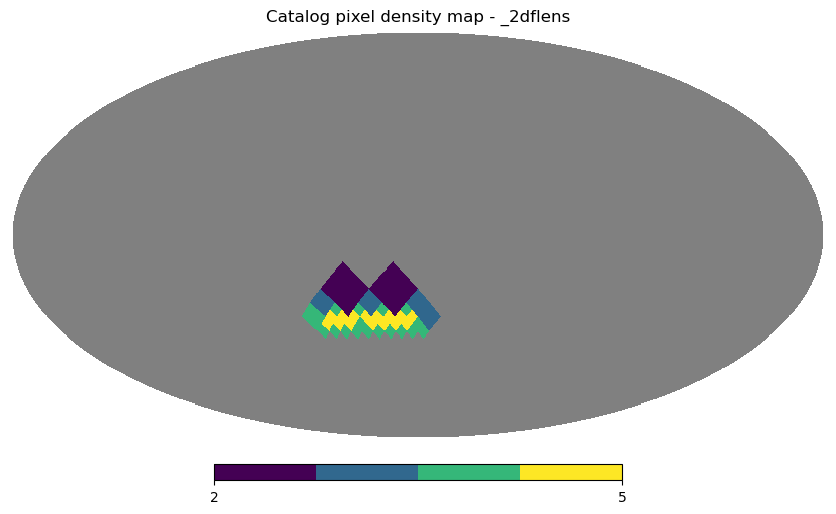

In [56]:
# Read the HiPSCat catalog metadata, it does not load any data, just healpix pixels and other metadata
_2dflens_hipscat_catalog = Catalog.read_from_hipscat(_2DFLENS_HIPSCAT_DIR)
plot_pixels(_2dflens_hipscat_catalog)

## Conversão para o formato hipscat dos dados fotométricos

Exemplos de referência: <br>
https://lsdb.readthedocs.io/en/stable/tutorials/pre_executed/des-gaia.html <br>
https://hipscat-import.readthedocs.io/en/stable/catalogs/public/sdss.html <br>

Definindo os diretórios para os dados:

In [57]:
# Change to the directories where the data will be stored
DES_DIR = Path("/home/luigi.silva/hipscat_data/input/photoz/")

DES_HIPSCAT_NAME = "des_dr2"

HIPSCAT_DIR = Path("/home/luigi.silva/hipscat_data/hipscat/")
DES_HIPSCAT_DIR = HIPSCAT_DIR / DES_HIPSCAT_NAME

Convertendo os dados para o formato hipscat:

In [58]:
#des_args = ImportArguments(
#    sort_columns="coadd_object_id",
#    ra_column="ra",
#    dec_column="dec",
#    input_path=DES_DIR,
#    file_reader="parquet",
#    output_artifact_name=DES_HIPSCAT_NAME,
#    output_path=HIPSCAT_DIR,
#    pixel_threshold=10_000,
#    # Uncomment to overwrite existing catalog
#    # overwrite=True
#)

#runner.pipeline(des_args)

Fazendo o plot dos pixels:

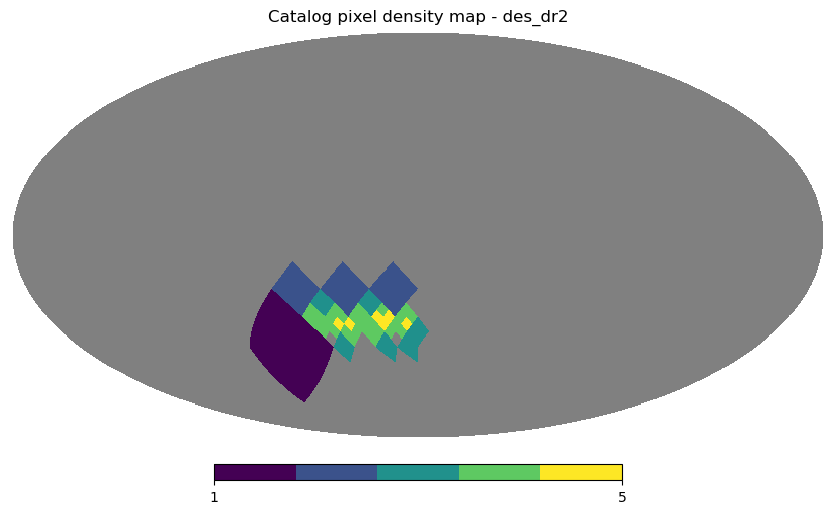

In [59]:
# Read the HiPSCat catalog metadata, it does not load any data, just healpix pixels and other metadata
des_hipscat_catalog = Catalog.read_from_hipscat(DES_HIPSCAT_DIR)
plot_pixels(des_hipscat_catalog)

In [62]:
data_test = lsdb.read_hipscat(DES_HIPSCAT_DIR)

In [68]:
data_test.compute()

coadd_object_id         ra        dec  mag_auto_g_dered  \
_hipscat_index                                                                  
4617315212767264768        1048243709   2.785144 -35.720956         22.295458   
4617315517760274432        1048240282   2.812806 -35.686354         22.393759   
4617596717489979392        1052391112   4.197330 -35.709448         23.566193   
4617689010674860032        1062367900   5.425824 -35.728932         23.343117   
4617690141866065920        1062366507   5.519986 -35.715197         23.216444   
...                               ...        ...        ...               ...   
10241794012516188160       1224101539  30.031315 -26.280664         23.581026   
10241794807806558208       1224102386  29.942372 -26.293036         19.883896   
10241801361423335424       1230650493  30.245015 -26.259595         22.250174   
10241818921770418176       1230650817  30.578913 -26.262965         22.638069   
10241818979605676032       1230649705  30.594819 -26.256638         20.916700   

                      mag_auto_r_dered  mag_auto_i_dered  mag_auto_z_dered  \
_hipscat_index                                                               
4617315212767264768          21.334402         20.954721         20.722973   
4617315517760274432          21.878805         21.788544         21.666271   
4617596717489979392          23.282799         22.604336         21.969831   
4617689010674860032          23.061638         22.639044         22.324106   
4617690141866065920          22.810978         22.249069         22.186733   
...                                ...               ...               ...   
10241794012516188160         22.509560         22.127392         21.877935   
10241794807806558208         19.321104         19.028488         18.932543   
10241801361423335424         21.227854         20.914278         20.694963   
10241818921770418176         22.182066         22.079882         22.183405   
10241818979605676032         19.452442         18.959976         18.623030   

                      mag_auto_y_dered  magerr_auto_g  magerr_auto_r  \
_hipscat_index                                                         
4617315212767264768          20.536945       0.028443       0.016223   
4617315517760274432          21.530128       0.033475       0.029751   
4617596717489979392          21.755011       0.092799       0.098902   
4617689010674860032          21.414036       0.062359       0.068319   
4617690141866065920          22.156544       0.064606       0.063661   
...                                ...            ...            ...   
10241794012516188160         21.693659       0.091546       0.038974   
10241794807806558208         18.981592       0.004162       0.002783   
10241801361423335424         20.485975       0.035846       0.017599   
10241818921770418176         22.274717       0.039530       0.032229   
10241818979605676032         18.479572       0.015907       0.005123   

                      magerr_auto_i  magerr_auto_z  magerr_auto_y  flags_g  \
_hipscat_index                                                               
4617315212767264768        0.020698       0.032710       0.089722        0   
4617315517760274432        0.046978       0.087265       0.270773        0   
4617596717489979392        0.109369       0.098787       0.262593        3   
4617689010674860032        0.086161       0.118483       0.203919        0   
4617690141866065920        0.074320       0.124845       0.482733        0   
...                             ...            ...            ...      ...   
10241794012516188160       0.060058       0.086472       0.284207        0   
10241794807806558208       0.004272       0.007446       0.031316        3   
10241801361423335424       0.025093       0.040957       0.133881        0   
10241818921770418176       0.055256       0.118727       0.434311        0   
10241818979605676032       0.005290       0.007754       0.021631        3   

 

# Utilizando o LSDB

## Instalação do LSDB


## X-matching usando o LSDB

## Análise dos resultados do X-matching